In [93]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Union
import os

In [94]:
M = 1.989e30 #kg
G = 6.6741e-11 # m^3/kg/s^2
AU = 149597870700 #m
BUFFOR = int(1e7)

In [95]:
x0 = np.array([0, 0.586]) * AU # m
v0 = np.array([54600, 0]) # m/s


In [96]:
def error(x1: np.ndarray, x2: np.ndarray, n: int) -> float:
    u = (x1 - x2) / (2**n-1)
    output = u.max()
    if output == 0:
        return 1e-15
    else:
        return abs(output)

In [97]:
def a(r: np.ndarray):
    return -G * M * r / np.power(np.sqrt(r[0] ** 2 + r[1] ** 2), 3)
    

In [98]:
class Euler:
    def __init__(self, tmax: int, dt: float, tol: float = None):
        self.x = None
        self.v = None
        self.t = None
        self.dt = None
        self.tol = None
        self.update_params(tmax, dt, tol)

    def update_params(self, tmax: int, dt: float, tol: float):
        num = int(tmax//dt)
        self.x = np.zeros((num, 2))
        self.v = np.zeros((num, 2))
        self.t = np.linspace(0, tmax, num=num)
        self.tol = tol
        self.dt = dt

    def get_next_step(self, last_x, last_v, dt: float):
        # print(last_x, last_v)
        new_x = last_x + last_v * dt
        new_v = last_v + a(last_x) * dt
        return new_x, new_v
    
    def set_new_values(self, x: np.ndarray, v: np.ndarray, i):
        self.x[i] = x
        self.v[i] = v

    def calculate(self):
        for i in range(len(self.t)):
            if i == 0:
                self.set_new_values(x0, v0, 0)
                continue
            
            x, v = self.get_next_step(self.x[i-1], self.v[i-1], self.dt)
            if self.tol is None:
                self.set_new_values(x, v, i)
                continue
            xp1, vp1 = self.get_next_step(self.x[i-1], self.v[i-1], self.dt/2)
            xp2, vp2 = self.get_next_step(xp1, vp1, self.dt/2)
            eps = error(xp2, x, 1)
            self.dt = 0.9 * self.dt *(self.tol / eps)**(1/2)
            while eps > self.tol:
                x, v = self.get_next_step(self.x[i-1], self.v[i-1], self.dt/2)
                xp1, vp1 = self.get_next_step(self.x[i-1], self.v[i-1], self.dt/2)
                xp2, vp2 = self.get_next_step(xp1, vp1, self.dt/2)
                eps = error(xp2, x, 1)
                self.dt = 0.9 * self.dt*(self.tol / eps)**(1/2)
            
            self.set_new_values(xp2, vp2, i)

In [137]:
class RK4:
    def __init__(self, tmax: int, dt: float, tol: float = None):
        self.x = None
        self.v = None
        self.t = None
        self.dt = None
        self.tmax = None
        self.update_params(tmax, dt, tol)

    def update_params(self, tmax: int, dt: float, tol: float):
        self.x = np.zeros((BUFFOR, 2))
        self.v = np.zeros((BUFFOR, 2))
        self.tmax = tmax
        self.tol = tol
        
        self.t = np.zeros(BUFFOR)
        self.dt = dt
    
    def k(self, last_x, last_v, dt: float) -> np.ndarray:
        output = np.zeros((4, 4))
        output[0, :2] = last_v
        output[0, 2:] = a(last_x)

        output[1, :2] = last_v + output[0, 2:] * dt / 2
        output[1, 2:] = a(last_x + output[0, :2] * dt / 2)

        output[2, :2] = last_v + output[1, 2:] * dt / 2
        output[2, 2:] = a(last_x + output[1, :2] * dt / 2)

        output[3, :2] = last_v + output[2, 2:] * dt
        output[3, 2:] = a(last_x + output[2, :2] * dt)
        return output
    
    def get_new_values(self, last_x: np.ndarray, last_v: np.ndarray, dt: float):
        k = self.k(last_x, last_v, dt)
        new_x = last_x + dt / 6 * (k[0, :2] + 2*k[1, :2] + 2*k[2, :2] + k[3, :2])
        new_v = last_v + dt / 6 * (k[0, 2:] + 2*k[1, 2:] + 2*k[2, 2:] + k[3, 2:])
        return new_x, new_v

    def set_new_values(self, x, v, i):
        self.x[i] = x
        self.v[i] = v
        self.t[i] = self.t[i-1] + self.dt
        # print(self.t[i])

    def calculate(self):
        self.x[0] = x0
        self.v[0] = v0
        i = 1
        while self.t[i-1] < self.tmax:
            x, v = self.get_new_values(self.x[i-1], self.v[i-1], self.dt)
            if self.tol is None:
                self.set_new_values(x, v, i)
                i+=1
                continue
            xp1, vp1 = self.get_new_values(self.x[i-1], self.v[i-1], self.dt/2)
            xp2, vp2 = self.get_new_values(xp1, vp1, self.dt/2)
            eps = error(xp2, x, 4)
            self.dt = 0.9 * self.dt *(self.tol / eps)**(1/5)
            while eps > self.tol:
                x, v = self.get_new_values(self.x[i-1], self.v[i-1], self.dt/2)
                xp1, vp1 = self.get_new_values(self.x[i-1], self.v[i-1], self.dt/2)
                xp2, vp2 = self.get_new_values(xp1, vp1, self.dt/2)
                eps = error(xp2, x, 4)
                self.dt = 0.9 * self.dt*(self.tol / eps)**(1/5)
            
            self.set_new_values(xp2, vp2, i)
            i+=1
        self.x = self.x[:i]
        self.v = self.v[:i]
        self.t = self.t[:i]

    def speed(self):
        output = np.zeros(len(self.t))
        output = np.sqrt(self.v[:, 0]**2 + self.v[:, 1]**2)
        return output



In [138]:
class Plotter:
    def __init__(self, solver: Euler, dir: str):
        self.solver = solver
        self.dir = dir
        if not os.path.exists(dir):
            os.makedirs(dir)
        

    def plot(self, filename: str):
        fig, [ax1, ax2] = plt.subplots(2, 1)
        ax1.plot(self.solver.x[:, 0]/AU, self.solver.x[:, 1]/AU)
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax2.plot(self.solver.t, self.solver.x[:, 1]/AU)
        ax2.set_xlabel('t')
        ax2.set_ylabel('y')
        fig.savefig(f"{self.dir}/{filename}.png")



In [156]:
class Handler:
    def __init__(self):
        self.dir = "output"
    
    def euler_fixed_dt(self):
        solver = Euler(500000000, 2000)
        solver.calculate()
        plotter = Plotter(solver, self.dir)
        plotter.plot("euler_fixed")
        return solver

    def euler_changing_dt(self):
        solver = Euler(500000000, 2000, 500)
        solver.calculate()
        plotter = Plotter(solver, self.dir)
        plotter.plot("euler_changing")
        return solver

    def rk4_fixed_dt(self):
        solver = RK4(5000000000, 2000)
        solver.calculate()
        plotter = Plotter(solver, self.dir)
        plotter.plot("rk4_fixed")
        return solver
    def rk4_changing_dt(self):
        solver = RK4(10000000000, 2000, 100)
        solver.calculate()
        plotter = Plotter(solver, self.dir)
        plotter.plot("rk4_fixed")
        return solver

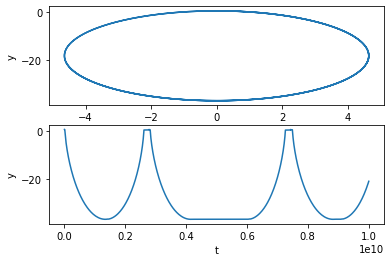

In [157]:
h = Handler()
s2 = h.rk4_changing_dt()

In [136]:
BUFFOR

10000000